In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
# block size is the context length: how many chars do we take to predict the next one
def build_dataset(words):
    block_size = 3 
    x, y =[],[]
    for w in words:
        #print(w)
        context = [0] * block_size # initializing the block with ... padding
        for ch in w + '.': #to mark the ending of a word
            ix = stoi[ch]
            x.append(context) # this is where it is intially padded with dots....
            y.append(ix) # index of the next character
            #print(''.join(itos[i] for i in context),'---->',itos[ix])
            context = context[1:] + [ix] #crop and append the character for next iteration(decrease the padded dots)
        
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape,y.shape)
    return x,y
#print(x[1,:])
#print(y[1])
#from the above print example you can see that X is a possible context
#before the next character which is y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xtr, ytr = build_dataset(words[:n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647)
c = torch.rand((27,10),generator=g)
# hidden layer
w1 = torch.randn((30,400),generator=g)
b1 = torch.randn(400,generator=g)
# final layer
w2 = torch.randn((400,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [c, w1, b1, w2, b2]

In [6]:
sum(p.nelement() for p in parameters)  # number of parameters in total

23497

In [7]:
for p in parameters:
    p.requires_grad =  True

In [8]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lossi = []
lri = []
stepi = []

In [9]:
######### Forward pass #########
# view() is used to reshape (32,3,2) in to (32,6) for matrix multiplication purpose
for i in range(250000):
    # implementing mini batches so that we dont take much time 
    # forwarding and backwarding on the whole dataset at once
    # mini batch construct
    ix = torch.randint(0, xtr.shape[0],(64,))
    
    
    emb = c[xtr[ix]]  #(32,3,2)
    h =torch.tanh(emb.view(emb.shape[0],30) @ w1 + b1)
    logits = h @ w2 + b2  # (32,27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(228146),y].log().mean()
    batch_loss= F.cross_entropy(logits, ytr[ix])
    #So, in summary, you can interpret the .log() 
    # computation as undoing the exponential 
    # transformation performed earlier, allowing for
    #  a linear scale representation of the probabilities
    #  and facilitating the calculation of the 
    # cross-entropy loss.


    ####### backward pass #########
    for p in parameters:
        p.grad = None
    batch_loss.backward()

    ######## update       ##########
    lr = 0.1 if i<150000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad
    # track status of learning rate
    #lri.append(lrs[i])
    lossi.append(batch_loss.log10().item())
    stepi.append(i)
print(batch_loss.item()) # for last batch computed lost

1.978005051612854


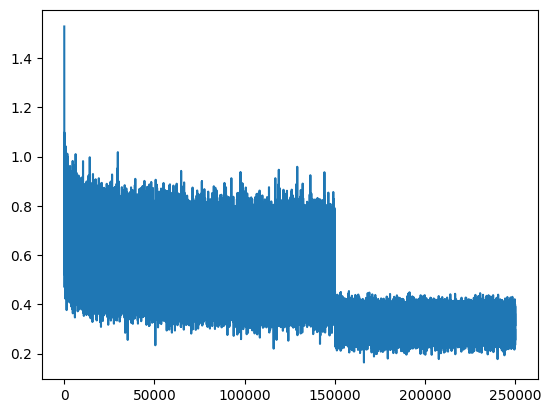

In [10]:
plt.plot(stepi,lossi)

ValueError: x and y must have same first dimension, but have shapes (0,) and (250000,)

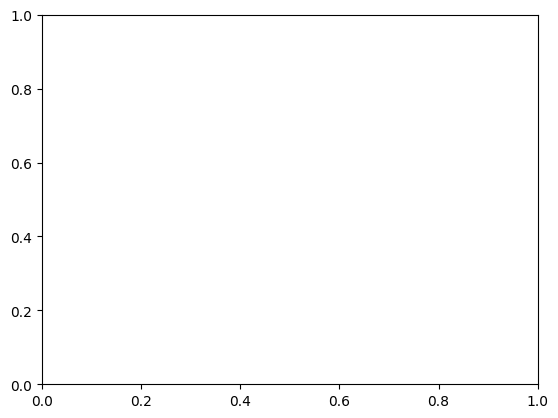

In [11]:
plt.plot(lri,lossi)

In [12]:
# general loss evaluation using test split data
emb = c[xtr]  #(32,3,2)
h =torch.tanh(emb.view(emb.shape[0],30) @ w1 + b1)
logits = h @ w2 + b2  # (32,27)
loss= F.cross_entropy(logits, ytr)
loss.item()

2.115145683288574

In [13]:
# general loss evaluation using the validation split data
emb = c[xdev]  #(32,3,2)
h =torch.tanh(emb.view(emb.shape[0],30) @ w1 + b1)
logits = h @ w2 + b2  # (32,27)
loss= F.cross_entropy(logits, ydev)
loss.item()

2.1564793586730957

In [ ]:
# training split/ dev or validation split/ test split
# 80%, 10%, 10%
# training data is used to train the parameters
# validation split is used to train the hyperparameters
#    hyperparameters are like size of the embeddings, lr, number of neurons
# test split is used to test the model

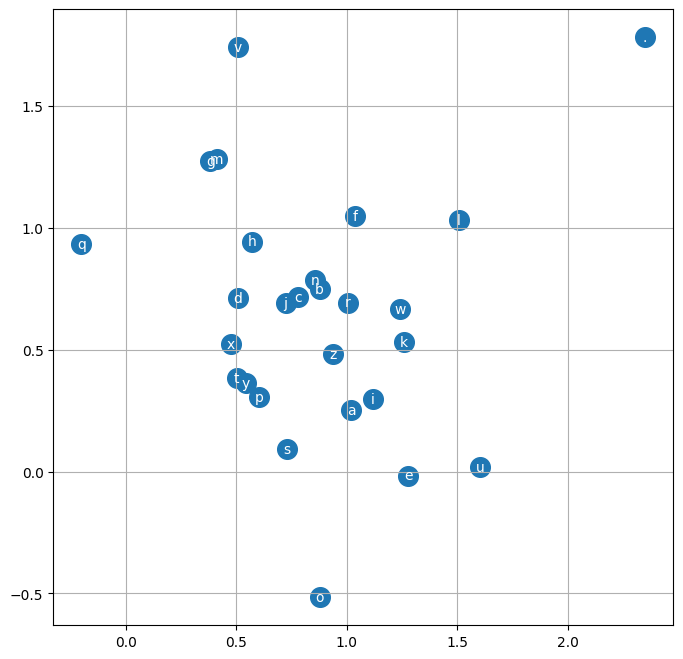

In [14]:
# visualizing the character embedding size
plt.figure(figsize=(8,8))
plt.scatter(c[:,0].data, c[:,1].data, s = 200)
for i in range(c.shape[0]):
    plt.text(c[i,0].item(), c[i,1].item(), itos[i], ha='center', va='center',color='white')
plt.grid('minor')

In [17]:
# sampling from the model
# tomorrow
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context  =  [0] * 3 #initialize with all ...
    while True:
        emb = c[torch.tensor([context])]  #(1,3(block size),d)
        h = torch.tanh(emb.view(1,-1)@w1+b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        print(''.join(itos[i] for i in out))
    print(''.join(itos[i] for i in out)+ "\n")

m
mo
mor
mora
mora.

k
ka
kay
kaya
kayan
kayann
kayanna
kayanna.

e
el
elm
elma
elmad
elmad.

r
ry
ryl
ryll
rylla
rylla.

e
em
emm
emma
emman
emmani
emmanie
emmanie.

d
dr
dra
dra.

g
gr
gra
grad
grade
gradee
gradeer
gradeer.

m
me
mel
meli
melin
melin.

s
sh
shi
shi.

j
je
jen
jen.

e
ed
ede
edel
edeli
edelis
edeliss
edelisso
edelisson
edelisson.

a
ar
arl
arle
arlei
arleit
arleitz
arleitzi
arleitzim
arleitzimo
arleitzimon
arleitzimont
arleitzimonta
arleitzimontal
arleitzimontali
arleitzimontalin
arleitzimontalin.

s
sh
shu
shub
shube
shuber
shuberg
shubergi
shubergih
shubergiha
shubergiham
shubergihami
shubergihamie
shubergihamiel
shubergihamiel.

k
ki
kin
kind
kindr
kindre
kindree
kindreel
kindreely
kindreelyn
kindreelynn
kindreelynn.

n
no
nop
noph
nophi
nophir
nophir.

u
ur
uri
uri.

g
ge
ged
gede
geder
geder.

y
ya
yar
yaru
yarul
yarulz
yarulze
yarulzeh
yarulzeh.

y
yu
yum
yumi
yumi.

m
my
mys
mys.

